In [8]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [13]:
def get_preprocessed_df(df: pd.DataFrame, base_imbalance_orderbook_level: int) -> pd.DataFrame:
    df['MidPrice'] = (df["AskPrice1"]+df["BidPrice1"])/2
    df['Return'] = (-df["MidPrice"]+df["MidPrice"].shift(-1)) / df["MidPrice"]

    pbid = df["BidPrice1"] - df[f"BidPrice{base_imbalance_orderbook_level}"]
    pask = df[f"AskPrice{base_imbalance_orderbook_level}"] - df["AskPrice1"]
    df["BaseImbalance"] = (pbid-pask)/(pbid+pask)

    df=df.dropna(subset=['Return', 'BaseImbalance'])
    df = df[df['Return'] != 0]
    df = df[['Timestamp', 'BaseImbalance', 'Return']]
    df['Diff'] = df['Timestamp'] - df['Timestamp'].shift(1)

    return df

def get_sliced_df(df: pd.DataFrame, end_time_training_millisec: int, train_duration_min: int) -> pd.DataFrame:
    orderbook_df = df[(df['Timestamp'] <= end_time_training_millisec) & 
                      (df['Timestamp'] >= end_time_training_millisec - (train_duration_min*60*1000))].copy()
    return orderbook_df

def get_orderbook_df_sliced(path: str, end_time_training_millisec: int, train_duration_min: int, base_imbalance_orderbook_level: int) -> pd.DataFrame:
    df = pd.read_csv(path, sep='\t')
    df = get_preprocessed_df(df, base_imbalance_orderbook_level)
    orderbook_df = get_sliced_df(df, end_time_training_millisec, train_duration_min)
    return orderbook_df

In [21]:
orderbook_df = get_orderbook_df_sliced(
    '/home/davide/Desktop/phd/bitfinex-api-py/data/orderbook_changes/orderbook_changes_1705074061033.tsv',
    1705072791000, 15, 8
)
orderbook_df['decay_saturated'] = True
print(orderbook_df)

           Timestamp  BaseImbalance    Return     Diff  decay_saturated
6390   1705071891982       0.285714  0.000022   1157.0             True
6395   1705071893188       0.241379 -0.000022   1206.0             True
6398   1705071893627       0.058824 -0.000011    439.0             True
6402   1705071894501       0.200000 -0.000011    874.0             True
6483   1705071910318       0.235294 -0.000198  15817.0             True
...              ...            ...       ...      ...              ...
11355  1705072764641       0.120000 -0.000022    208.0             True
11360  1705072765518       0.103448 -0.000033    877.0             True
11361  1705072765734       0.034483 -0.000011    216.0             True
11362  1705072765735       0.111111  0.000011      1.0             True
11363  1705072765957      -0.090909 -0.000033    222.0             True

[1428 rows x 5 columns]


In [22]:
orderbook_df2 = get_orderbook_df_sliced(
    '/home/davide/Desktop/phd/bitfinex-api-py/data/orderbook_changes/orderbook_changes_1705164940479.tsv',
    1705163925000, 15, 8
)
orderbook_df2['decay_saturated'] = False
orderbook_df = pd.concat([orderbook_df, orderbook_df2])

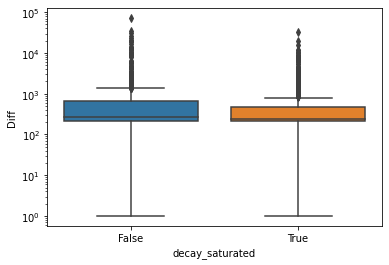

In [28]:
sns.boxplot(x='decay_saturated', y='Diff', data=orderbook_df)
plt.yscale('log')